# **Installazione Pythorch Geometric**

In [1]:
import torch
 
def format_pytorch_version(version):
  return version.split('+')[0]
 
TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)
 
def format_cuda_version(version):
  return 'cu' + version.replace('.', '')
 
CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)
 
!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 10.4 MB 5.0 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 3.7 MB 5.4 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 1.6 MB 5.2 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 870 kB 5.2 MB/s 
     |████████████████████████████████| 308 kB 5.5 MB/s 
     |████████████████████████████████| 407 kB 31.8 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.1-py3-none-any.whl size=513822 sha256=54ea6698691287daeb588f45cfbdf8eb60abe4060df586a0e6e84f05bbfd1464
  Stored in directory: /root/.cache/pip/wheels/78/3d/42/20589db73c66b5109fb93a0c5743edfd6ab5ca820a52afacfc
Successfully built torch

# **Installazione Igraph**

In [2]:
pip install python-igraph

     |████████████████████████████████| 3.2 MB 5.5 MB/s 


# **Installazione Cairo**

In [3]:
#Al fine di plottare i grafi
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
libgif-dev is already the newest version (5.1.4-2ubuntu0.1).
libgif-dev set to manually installed.
The following additional packages will be installed:
  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc
The following NEW packages will be installed:
  libcairo-script-interpreter2 libcairo2-dev libpixman-1-dev libxcb-shm0-dev
0 upgraded, 4 newly installed, 0 to remove and 37 not upgraded.
Need to get 930 kB of archives.
After this operation, 3,986 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcairo-script-interpreter2 amd64 1.15.10-2ubuntu0.1 [53.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libpixman-1-dev amd64 0.34.0-2 [244 kB]
Get:3 http://archive.ubuntu.com/ubuntu bio

# **Import**

In [4]:
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.data import DataListLoader
from sklearn.metrics import roc_curve, auc, roc_auc_score
import igraph
from igraph import *
from igraph import Graph
from igraph import GraphBase
import numpy as np
import numpy.ma as ma
import os
import random
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch_geometric.nn import GATConv
import time
from os import path as P
from datetime import datetime,timezone
import pytz
import itertools
import gc 
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
import math
import collections

In [5]:
#Da eseguire soltanto se viene utilizzato un runtime ospitato
def g_drive():
  from google.colab import drive
  drive.mount('/content/drive')

In [6]:
#Da eseguire soltanto se viene utilizzato un runtime ospitato
path = "/content/drive/My Drive/TesiMagistraleNodePruning/"
g_drive()

Mounted at /content/drive


In [ ]:
#Da eseguire soltanto se viene utilizzato un runtime locale
path = "/Users/andre/OneDrive/Documenti/TesiMagistraleNodePruning/"

In [7]:
dataset_testing = list(np.genfromtxt(path+"ListaGrafiTesting.txt",dtype=np.dtype(str)))
path_testing = path+"Testing/"
path_testing_salvataggi= path+"TestingSalvataggi/"
path_evaluation = path+"Evaluation/Evaluation.pt"
path_testing_performance = path+"TestingPerformance/DataframeTestingPerformance.pt"

# **Creazione Grafi**

In [8]:
# Chi-squared ([o]bserved, [e]xpected)
def chi(o, e):
    if e == 0:
        return 0
    return (o - e) ** 2 / e

In [9]:
"""Tale funzione consente di generare il file contenente gli identificativi e le features dei nodi"""
def generate_file_features(G, path):
  max_degree_graph = G.maxdegree()
  average_degree_graph = np.mean(G.degree())
  lcc_graph = G.transitivity_local_undirected()
  lcc_graph = [i if not math.isnan(i) else 0 for i in lcc_graph]
  average_lcc_graph = np.mean(lcc_graph)
  x = np.ndarray((G.vcount(),4))
  for i, node in enumerate(G.vs["name"]):
    normalized_node_degree = G.degree(node) / max_degree_graph
    x[i][0]= normalized_node_degree
    local_clustering_coefficient = G.transitivity_local_undirected(node)
    x[i][1]= local_clustering_coefficient if not math.isnan(local_clustering_coefficient) else 0
    node_chi_degree = chi(G.degree(node), average_degree_graph)
    x[i][2] = node_chi_degree
    node_chi_lcc = chi(x[i][1], average_lcc_graph)
    x[i][3] = node_chi_lcc
  nodes_id = np.array(G.vs["name"]).reshape((G.vcount(),1))
  x_with_nodes_id = np.concatenate((nodes_id,x), axis=1)
  np.savetxt(path+".features", x_with_nodes_id, fmt='%s')

In [10]:
"""Tale funzione consente di generare il file contenente i target dei nodi"""
def generate_file_target(G, path, id_nodi):
  y = np.ndarray((G.vcount(),))
  nodes_inside_largest_cliques = set()
  largest_cliques = G.largest_cliques()
  for clique in largest_cliques:
    for node in clique:
      nodes_inside_largest_cliques.add(node)
  nodes_inside_largest_cliques = list(nodes_inside_largest_cliques)
  """nodes_inside_largest_cliques, anziché contenere gli indici dei nodi appartenenti alla clique di dimensione massima, conterrà proprio
  l'identificativo di ogni singolo nodo appartenente alla clique di dimensione massima"""
  nodes_inside_largest_cliques = [id_nodi[index_node] for index_node in nodes_inside_largest_cliques]
  for i, node in enumerate(G.vs["name"]):
    if node in nodes_inside_largest_cliques:
      y[i]=1
    else:
      y[i]=0
  np.savetxt(path+".target", y, fmt="%s")

In [11]:
def crea_grafo(path, path1, graph):
 grafoPrincipaleGiaEsistente=False
 if P.exists(path+graph+".pt"): 
  print("Il Grafo "+graph + " è già presente all'interno della directory locale/remota, dunque lo carico")
  g=torch.load(path+graph+".pt")
  print("Il Grafo è costituito da un numero di Nodi pari a: ", g.vcount())
  print("Il Grafo è costituito da un numero di Archi pari a: ", g.ecount())
  grafoPrincipaleGiaEsistente=True
  
 if grafoPrincipaleGiaEsistente==False:

  print("Il Grafo "+graph +" non è presente all'interno della directory locale/remota, dunque lo creo")
  """Costruisco il Grafo principale considerando gli archi memorizzati all'interno del file .ncol"""
  g=Graph.Read_Ncol(path1+"ncol/"+graph+".ncol", directed=False)
  print("Il Grafo è costituito da un numero di Nodi pari a: ", g.vcount())
  print("Il Grafo è costituito da un numero di Archi pari a: ", g.ecount())
  print("Gli attributi del Grafo appena creato sono: ", g.vs.attribute_names())

  generate_file_features(g,path1+"features/"+graph)
  id_nodi = [g.vs[i]["name"] for i in range(0,g.vcount())]
  generate_file_target(g, path1+"target/"+graph, id_nodi)

  """Acquisisco l'identificativo e le features di ogni singolo nodo del Grafo memorizzate all'interno del file .features"""
  id_features_nodes = np.genfromtxt("{}{}.features".format(path1+"features/", graph),dtype=np.dtype(str))
  """Acquisisco il target (0 o 1) di ogni singolo nodo del Grafo memorizzato all'interno del file .target"""
  target_nodes = np.genfromtxt("{}{}.target".format(path1+"target/", graph),dtype=np.dtype(str))
  """Creo un dizionario costituito da un certo numero di coppie dove ogni singola coppia contiene come chiave l'identificativo del nodo
  e come valore una tupla contenente due informazioni: features del nodo - target (classe reale di appartenenza del nodo)"""
  features={}
  for j,i in enumerate(id_features_nodes):
    features[i[0]]=i[1:], target_nodes[j]
  #print("Dizionario Indice Nodo - Features Nodo - Target Nodo: ",features)
  classi=set() #inserisco le classi (0 e 1) in un set che utilizzeremo dopo per associare un colore ad ogni singola classe
  for k in features.keys():
    classi.add(features[k][1])
  print("classi",classi)
  
  color_dict={}
  colori=["yellow","red"]
  c=0
  for i in classi:
    color_dict[i]=colori[c]
    c=c+1
  c=0
  print("dizionario colori",color_dict)

  """nodi conterrà i nodi del Grafo principale che NON sono None"""
  nodi=[]
  """All'interno del Grafo, come attributi, andiamo ad aggiungere le features di ogni singolo nodo e la classe reale di appartenenza di ogni singolo nodo"""
  for v in g.vs:
    id_nodo=v["name"]
    if id_nodo in features.keys():  
      v["features"]=(features[v["name"]][0]).astype(float)
      v["target"]=(features[v["name"]][1]).astype(float)
      nodi.append(v.index)
  """A questo punto considerando solo ed esclusivamente gli indici dei Nodi presenti in nodi andiamo a costruire un nuovo sottografo
  che andrà a sovrascrivere il Grafo principale. In pratica, così facendo, dal Grafo principale stiamo rimuovendo tutti i Nodi che sono None"""
  g=g.subgraph(nodi)

  g.vs["color"] = [color_dict[str(classe)] for classe in g.vs["target"]]  #aggiungo i colori che servono per il plot del grafo

  print("Il Grafo finale "+graph +" è costituito da un numero di Nodi pari a: ", g.vcount())
  print("Il Grafo finale "+graph +" è costituito da un numero di Archi pari a: ", g.ecount())
  print("Gli attributi del Grafo finale sono: ", g.vs.attribute_names())

  """Memorizzo il Grafo Principale in maniera tale da poterlo riutilizzare successivamente"""
  torch.save(g,path+graph+".pt")
  print("Grafo memorizzato con successo")
 return g

In [12]:
dizionario_grafi = dict()
temp = []
print("TESTING")
for graph in dataset_testing:
  print("Grafo: ", graph)
  g = crea_grafo(path_testing_salvataggi,path_testing, graph)
  temp.append(g)
  print("-------------------------------------------------------------------------------------")
dizionario_grafi["Testing"]= temp
print(dizionario_grafi)

TESTING
Grafo:  ca-citeseer
Il Grafo ca-citeseer è già presente all'interno della directory locale/remota, dunque lo carico
Il Grafo è costituito da un numero di Nodi pari a:  227320
Il Grafo è costituito da un numero di Archi pari a:  814134
-------------------------------------------------------------------------------------
Grafo:  ca-dblp-2010
Il Grafo ca-dblp-2010 è già presente all'interno della directory locale/remota, dunque lo carico
Il Grafo è costituito da un numero di Nodi pari a:  226413
Il Grafo è costituito da un numero di Archi pari a:  716460
-------------------------------------------------------------------------------------
Grafo:  ca-dblp-2012
Il Grafo ca-dblp-2012 è già presente all'interno della directory locale/remota, dunque lo carico
Il Grafo è costituito da un numero di Nodi pari a:  317080
Il Grafo è costituito da un numero di Archi pari a:  1049866
-------------------------------------------------------------------------------------
Grafo:  rt-retweet-crawl

# **Creazione Dataset**

In [13]:
def create_data(g, path, graph):
 datasetGiaEsistente=False
 if P.exists(path+"Dataset"+graph+".pt"): 
   print("Il dataset del Grafo "+graph + " è già presente all'interno della directory locale/remota, dunque lo carico")
   data=torch.load(path+"Dataset"+graph+".pt")
   datasetGiaEsistente=True
   return data
 if datasetGiaEsistente==False:
  """Creo la matrice x, ossia la matrice contenente un numero di righe pari al numero di nodi e un numero di colonne pari al
  numero di features di ogni singolo nodo"""
  x=[g.vs[i]["features"] for i in range(0,g.vcount())]
  id_nodi = [g.vs[i]["name"] for i in range(0,g.vcount())]
  x=np.column_stack(tuple([[float(y) for y in x] for x in x]))
  x = torch.from_numpy(x).to(torch.float)
  x=x.t()
  """Creo la matrice edge_index, ossia la matrice che mantiene le informazioni riguardanti gli archi che collegano i diversi nodi"""
  edge_index = np.empty((2, 2 * g.ecount()), dtype=np.int32)
  i = 0
  for e in g.get_edgelist():
    edge_index[:, i] = (g.vs[e[0]].index, g.vs[e[1]].index)
    edge_index[:, i + 1] = (g.vs[e[1]].index, g.vs[e[0]].index)
    i += 2

  if len(edge_index[0])==0:
    edge_index = np.zeros((2, 2), dtype=np.int32)
  
  edge_index = torch.from_numpy(edge_index).to(torch.long)
  
  #Creo la matrice y, la quale conterrà i target associati ai nodi
  y=[]
  for i, node in enumerate(g.vs):
    y.append(node["target"])
  y=torch.FloatTensor(y)

  data = Data(x=x.contiguous(), edge_index=edge_index.contiguous(), y=y.contiguous(), id_nodi=id_nodi)
  torch.save(data,path+"Dataset"+graph+".pt")
  print("Il dataset del Grafo è stato memorizzato con successo")
  return data

In [14]:
dizionario_dataset = dict()
temp = []
print("TESTING")
for i, graph in enumerate(dataset_testing):
  print("Grafo: ", graph)
  data = create_data(dizionario_grafi["Testing"][i], path_testing_salvataggi, graph)
  temp.append(data)
  print("-------------------------------------------------------------------------------------")
dizionario_dataset["Testing"]= temp
print(dizionario_dataset)

TESTING
Grafo:  ca-citeseer
Il dataset del Grafo ca-citeseer è già presente all'interno della directory locale/remota, dunque lo carico
-------------------------------------------------------------------------------------
Grafo:  ca-dblp-2010
Il dataset del Grafo ca-dblp-2010 è già presente all'interno della directory locale/remota, dunque lo carico
-------------------------------------------------------------------------------------
Grafo:  ca-dblp-2012
Il dataset del Grafo ca-dblp-2012 è già presente all'interno della directory locale/remota, dunque lo carico
-------------------------------------------------------------------------------------
Grafo:  rt-retweet-crawl
Il dataset del Grafo rt-retweet-crawl è già presente all'interno della directory locale/remota, dunque lo carico
-------------------------------------------------------------------------------------
Grafo:  rt-higgs
Il dataset del Grafo rt-higgs è già presente all'interno della directory locale/remota, dunque lo carico


# **Eseguiamo l'algoritmo di Garbage Collection e svuotiamo la GPU**

In [15]:
gc.collect()
torch.cuda.empty_cache()

# **Modello**

In [16]:
from torch.nn import functional as F
from torch.autograd import Variable
class GAT(nn.Module):

  #INIT
  def __init__(self, h_sizes, out_size, inOutDim,head,layerLin,linear):
    super(GAT, self).__init__()
    
    torch.manual_seed(0)
    #Hidden Layers GAT
    self.hidden = nn.ModuleList()
    if h_sizes>1:
      for k in range(h_sizes-1):
          self.hidden.append(GATConv(inOutDim[k]*head[k-1] if k!=0 else inOutDim[k] ,inOutDim[k+1],heads=head[k]))
      # LAST LAYER GAT
      self.hidden.append(GATConv(inOutDim[-1]*head[-2], linear[0],heads=1,concat=False))
    else :
      self.hidden.append(GATConv(inOutDim[0]*head[0], linear[0],heads=1,concat=False))
  
    #FULLY-CONNECTED (LINEAR) LAYERS
    self.fc = nn.ModuleList()
    for k in range(0,layerLin):
        self.fc.append(nn.Linear(linear[k], 1 if k+2>len(linear) else linear[k+1]))

  #FORWARD
  def forward(self, data,device):
    x, edge_index= data.x, data.edge_index
    for layer in self.hidden:
      x = layer(x,edge_index)
      x= F.elu(x)
      
    for layer in self.fc:
      x=layer(x)
      #x=F.relu(x)

    x=torch.sigmoid(x)
  
    x = x.view(x.size(0))
    return x

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if P.exists(path_evaluation): #controllo se ci sono i salvataggi
  print("alcune prove sono già state fatte")
  salvataggi=torch.load(path_evaluation, map_location=torch.device(device))
else:
  print("ancora non ci sono prove")
  salvataggi={}

alcune prove sono già state fatte


# **Testing**

In [18]:
largest_cliques_grafi_before_pruning = {}
solver_execution_time_graphs_before_pruning = {}

In [19]:
def before_pruning():
  for i in range(0, len(dizionario_grafi["Testing"])):
    print(i)
    since = time.time()
    largest_cliques_grafi_before_pruning[dataset_testing[i]] = [[dizionario_grafi["Testing"][i].vs["name"][indice_nodo] for indice_nodo in clique] for clique in dizionario_grafi["Testing"][i].largest_cliques()]
    time_elapsed = time.time() - since
    solver_execution_time_graphs_before_pruning[dataset_testing[i]] = round(time_elapsed,2)
  torch.save(solver_execution_time_graphs_before_pruning, path_testing_salvataggi + "SolverExecutionTimeBeforePruning.pt")
  torch.save(largest_cliques_grafi_before_pruning, path_testing_salvataggi + "LargestCliquesBeforePruning.pt")

In [20]:
if P.exists(path_testing_salvataggi + "SolverExecutionTimeBeforePruning.pt") and P.exists(path_testing_salvataggi + "LargestCliquesBeforePruning.pt"):
    print("Il dizionario solver_execution_time_graphs_before_pruning e il dizionario largest_cliques_grafi_before_pruning sono già presenti all'interno della directory TestingSalvataggi, dunque li carico")
    solver_execution_time_graphs_before_pruning = torch.load(path_testing_salvataggi + "SolverExecutionTimeBeforePruning.pt")
    largest_cliques_grafi_before_pruning = torch.load(path_testing_salvataggi + "LargestCliquesBeforePruning.pt")
else:
    before_pruning()

Il dizionario solver_execution_time_graphs_before_pruning e il dizionario largest_cliques_grafi_before_pruning sono già presenti all'interno della directory TestingSalvataggi, dunque li carico


In [21]:
dizionario_grafi_testing_after_pruning_soglia_specifica = dict()
largest_cliques_grafi_after_pruning_soglia_specifica = dict()
solver_execution_time_pruned_graphs_soglia_specifica = dict()  #in tale dizionario avremo i tempi per eseguire l'algoritmo che trova la largest clique considerando i grafi di testing prunati
edge_pruning_rate_soglia_specifica = dict()
node_pruning_rate_soglia_specifica = dict()
speedup_soglia_specifica = dict()
tpr = dict()
fpr = dict()
roc_auc = dict()
dict_predictions_all_graphs = dict()

In [22]:
def get_prediction(modello, dataset_grafo, device):
  modello.eval()  # Set model to evaluation mode
  torch.set_grad_enabled(False)
  uscita = modello(dataset_grafo,device)
  return uscita #uscita contiene le probabilità con cui i nodi del grafo fanno parte della clique di dimensione massima

In [23]:
def pruning(g, dataset_grafo, uscita, soglia):
  indici_nodi = []
  for nodo in g.vs:
    indici_nodi.append(nodo.index)
  indici_nodi_after_pruning = [indice_nodo for indice_nodo in indici_nodi if uscita[indice_nodo] > soglia]
  grafo_after_pruning = g.subgraph(indici_nodi_after_pruning)
  return grafo_after_pruning

#Valutazione Performance del Modello migliore in fase di Testing **al variare della soglia**

In [24]:
thresholds = torch.arange(0,1.05,0.05)
#thresholds = torch.arange(0,1.05,0.5)
print(thresholds)

tensor([0.0000, 0.0500, 0.1000, 0.1500, 0.2000, 0.2500, 0.3000, 0.3500, 0.4000,
        0.4500, 0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500,
        0.9000, 0.9500, 1.0000])


In [25]:
dict_similarities_for_each_graph = dict()
dict_speedups_for_each_graph = dict()

In [26]:
def similarity_soglia_variabile(largest_cliques_grafo_after_pruning_soglia, largest_cliques_grafo_before_pruning):
  if  not largest_cliques_grafo_after_pruning_soglia:
    return 0.0
  if len(largest_cliques_grafo_after_pruning_soglia[0]) == len(largest_cliques_grafo_before_pruning[0]):
    similarity = round((len(largest_cliques_grafo_after_pruning_soglia) / len(largest_cliques_grafo_before_pruning)), 2)*100
  else:
    similarity = 0.0
  return similarity

In [27]:
def test_best_model_soglia_variabile(best_model):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  for i in range(0,len(dizionario_grafi["Testing"])):
    print(i)
    lista_similarities = []
    lista_speedups = []
    uscita = get_prediction(best_model,dizionario_dataset["Testing"][i].to(device),device)
    for soglia in thresholds:
      graph_object = pruning(dizionario_grafi["Testing"][i], dizionario_dataset["Testing"][i].to(device), uscita, soglia.item())
      since = time.time()
      largest_cliques_after_pruning_soglia = [[graph_object.vs["name"][indice_nodo] for indice_nodo in clique] for clique in graph_object.largest_cliques()]
      time_elapsed = time.time() - since
      solver_execution_time_pruned_graph_soglia = round(time_elapsed,2)
      speedup = solver_execution_time_graphs_before_pruning[dataset_testing[i]]/solver_execution_time_pruned_graph_soglia if solver_execution_time_pruned_graph_soglia != 0 else 1.0
      lista_speedups.append(round(speedup,2))
      #print(largest_cliques_after_pruning_soglia)
      #print(largest_cliques_grafi_before_pruning[dataset_testing[i]])
      similarity_soglia = similarity_soglia_variabile(largest_cliques_after_pruning_soglia, largest_cliques_grafi_before_pruning[dataset_testing[i]])
      lista_similarities.append(similarity_soglia)
    dict_speedups_for_each_graph[dataset_testing[i]] = lista_speedups
    dict_similarities_for_each_graph[dataset_testing[i]] = lista_similarities

In [28]:
best_model = salvataggi["modello 0"]["modello"]
test_best_model_soglia_variabile(best_model)

0
1
2
3
4
5
6
7
8
9
10
11


#Valutazione Performance del Modello migliore in fase di Testing fissata una **soglia specifica**

In [37]:
def test_best_model_soglia_specifica(best_model,soglia):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  for i in range(0,len(dizionario_grafi["Testing"])):
    print(i)
    uscita = get_prediction(best_model,dizionario_dataset["Testing"][i].to(device),device)
    dizionario_grafi_testing_after_pruning_soglia_specifica[dataset_testing[i]]= pruning(dizionario_grafi["Testing"][i], dizionario_dataset["Testing"][i].to(device), uscita, soglia)
    fpr[dataset_testing[i]], tpr[dataset_testing[i]], _ = roc_curve(dizionario_dataset["Testing"][i].y.cpu(), uscita.cpu().numpy())
    roc_auc[dataset_testing[i]] = roc_auc_score(dizionario_dataset["Testing"][i].y.cpu(), uscita.cpu().numpy())
    dict_predictions_all_graphs[dataset_testing[i]] = uscita
    since = time.time()
    largest_cliques_grafi_after_pruning_soglia_specifica[dataset_testing[i]] = [[dizionario_grafi_testing_after_pruning_soglia_specifica[dataset_testing[i]].vs["name"][indice_nodo] for indice_nodo in clique] for clique in dizionario_grafi_testing_after_pruning_soglia_specifica[dataset_testing[i]].largest_cliques()]
    time_elapsed = time.time() - since
    solver_execution_time_pruned_graphs_soglia_specifica[dataset_testing[i]]= round(time_elapsed,2)
    speedup = solver_execution_time_graphs_before_pruning[dataset_testing[i]]/solver_execution_time_pruned_graphs_soglia_specifica[dataset_testing[i]] if solver_execution_time_pruned_graphs_soglia_specifica[dataset_testing[i]] != 0 else 1.0
    speedup_soglia_specifica[dataset_testing[i]] = round(speedup,2)
    edge_pruning_rate_soglia_specifica[dataset_testing[i]] = round(((dizionario_grafi["Testing"][i].ecount() - dizionario_grafi_testing_after_pruning_soglia_specifica[dataset_testing[i]].ecount()) *100) / dizionario_grafi["Testing"][i].ecount(), 2)
    node_pruning_rate_soglia_specifica[dataset_testing[i]] = round(((dizionario_grafi["Testing"][i].vcount() - dizionario_grafi_testing_after_pruning_soglia_specifica[dataset_testing[i]].vcount()) *100) / dizionario_grafi["Testing"][i].vcount(), 2)

In [38]:
best_model = salvataggi["modello 0"]["modello"]
test_best_model_soglia_specifica(best_model, 0.6)

0
1
2
3
4
5
6
7
8
9
10
11


######################################################################################################################################################
ca-citeseer


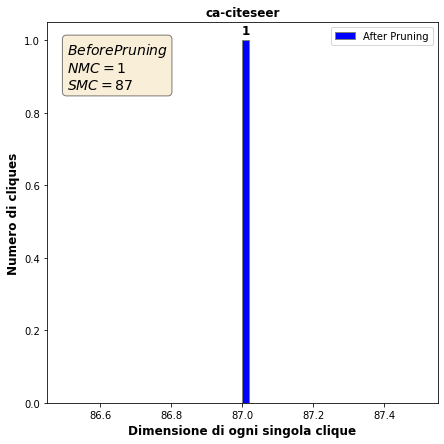

######################################################################################################################################################
ca-dblp-2010


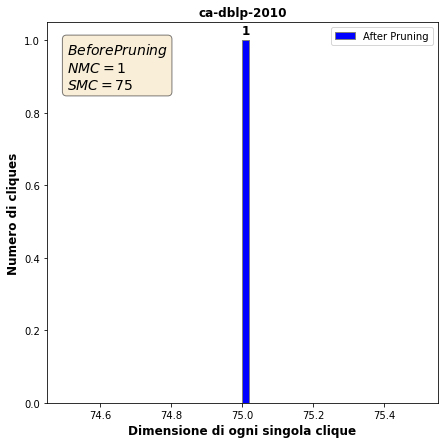

######################################################################################################################################################
ca-dblp-2012


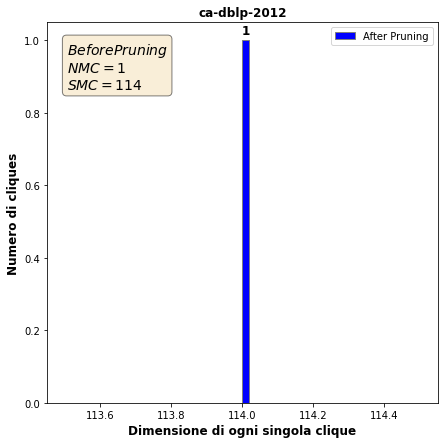

######################################################################################################################################################
rt-retweet-crawl


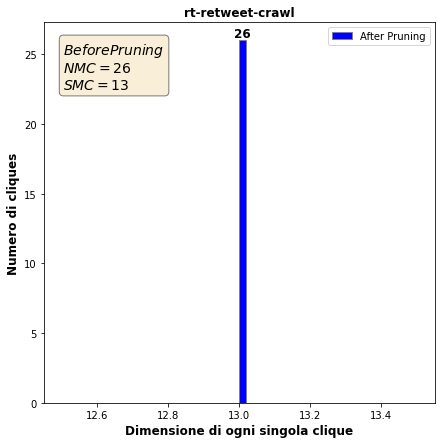

######################################################################################################################################################
rt-higgs


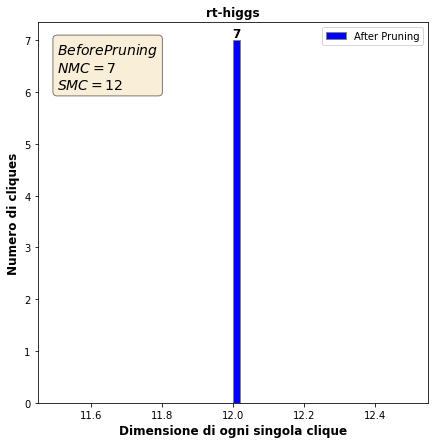

######################################################################################################################################################
soc-delicious


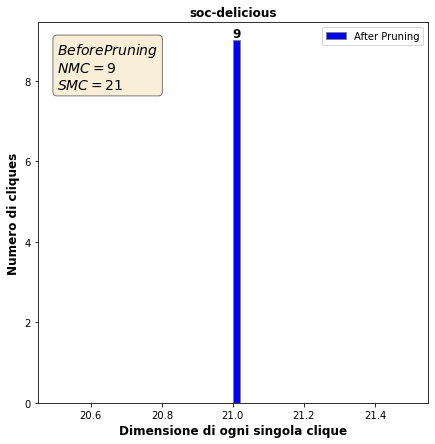

######################################################################################################################################################
soc-sign-Slashdot081106


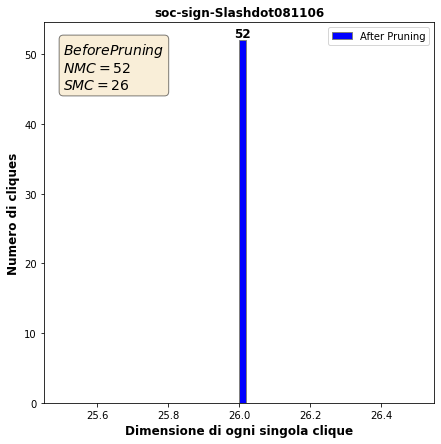

######################################################################################################################################################
soc-themarker


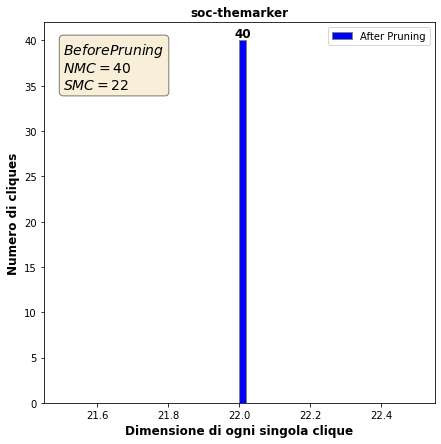

######################################################################################################################################################
web-baidu-baike-related


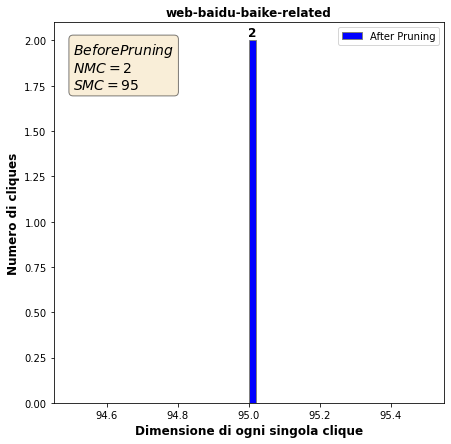

######################################################################################################################################################
socfb-OR


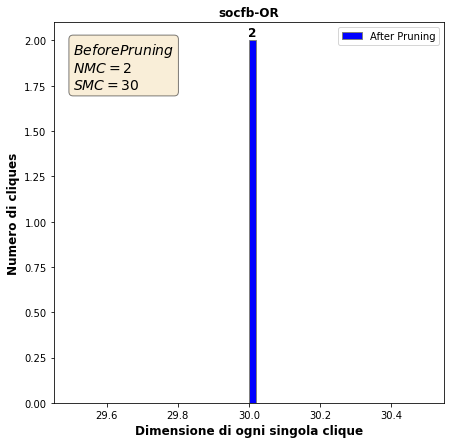

######################################################################################################################################################
socfb-wosn-friends


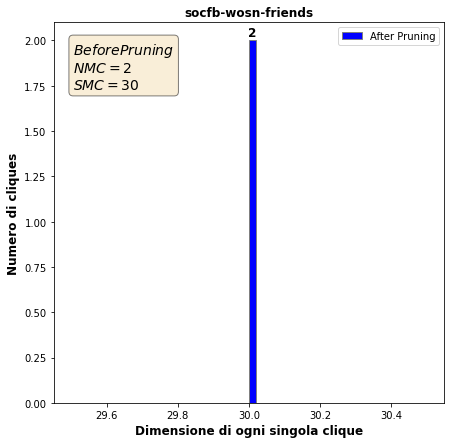

######################################################################################################################################################
tech-RL-caida


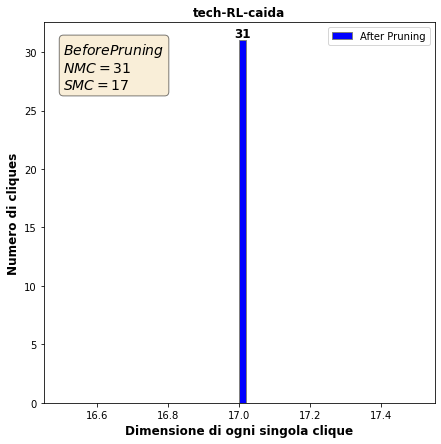

In [39]:
for i in range(0, len(dizionario_grafi["Testing"])):
  print("#"*150)
  print(dataset_testing[i])
  nodes_distribution_after_pruning = [len(clique) for clique in largest_cliques_grafi_after_pruning_soglia_specifica[dataset_testing[i]]]
  fig, ax = plt.subplots()
  text_before_pruning = '\n'.join((
    r'$BeforePruning$',
    r'$NMC=%.0f$' % (len(largest_cliques_grafi_before_pruning[dataset_testing[i]]), ),
    r'$SMC=%.0f$' % (len(largest_cliques_grafi_before_pruning[dataset_testing[i]][0]), )))
  """
  text_after_pruning = '\n'.join((
    r'$AfterPruning$',
    r'$NMC=%.0f$' % (len(largest_cliques_grafi_after_pruning_soglia_specifica[dataset_testing[i]]), ),
    r'$SMC=%.0f$' % (len(largest_cliques_grafi_after_pruning_soglia_specifica[dataset_testing[i]][0]), )))
  """
  counts, bins, patches = ax.hist(nodes_distribution_after_pruning, 50, label="After Pruning",facecolor='blue', edgecolor='grey')
  # these are matplotlib.patch.Patch properties
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  # place a text box in upper left in axes coords
  ax.text(0.05, 0.95, text_before_pruning, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
  """
  ax.text(0.05, 0.17, text_after_pruning, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
  """
  ax.legend()
  ax.set_xlabel("Dimensione di ogni singola clique",fontweight ='bold', fontsize = 12)
  ax.set_ylabel("Numero di cliques",fontweight ='bold', fontsize = 12)
  """Per aggiungere una label ad ogni singola barra"""
  rects = ax.patches
  for j, rect in enumerate(rects):
    if counts[j]!= 0:
      height = rect.get_height()
      ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, len(largest_cliques_grafi_after_pruning_soglia_specifica[dataset_testing[i]]), ha='center', va='bottom',fontsize=12, fontweight="bold")
  fig.set_figheight(7)
  fig.set_figwidth(7)
  plt.title(dataset_testing[i],fontweight ='bold')
  plt.show()

In [40]:
dizionario_grafi_testing_accuracy_soglia_specifica = {}

In [41]:
def similarity_soglia_specifica():
  for grafo in dataset_testing:
    if not largest_cliques_grafi_after_pruning_soglia_specifica[grafo]:
      dizionario_grafi_testing_accuracy_soglia_specifica[grafo] = 0
      continue
    if len(largest_cliques_grafi_after_pruning_soglia_specifica[grafo][0]) == len(largest_cliques_grafi_before_pruning[grafo][0]):
      dizionario_grafi_testing_accuracy_soglia_specifica[grafo] = round((len(largest_cliques_grafi_after_pruning_soglia_specifica[grafo]) / len(largest_cliques_grafi_before_pruning[grafo])), 2)*100
    else:
      dizionario_grafi_testing_accuracy_soglia_specifica[grafo] = 0

In [42]:
similarity_soglia_specifica()

In [43]:
edge_pruning_rates = []
node_pruning_rates = []
time_before_pruning = []
time_after_pruning = []
speedups = []
graphs_similarity = []
for grafo in dataset_testing:
  t_before_pruning = solver_execution_time_graphs_before_pruning[grafo]
  t_after_pruning = solver_execution_time_pruned_graphs_soglia_specifica[grafo]
  edge_pruning_rates.append(str(edge_pruning_rate_soglia_specifica[grafo])+ "%")
  node_pruning_rates.append(str(node_pruning_rate_soglia_specifica[grafo])+ "%")
  time_before_pruning.append("{:.0f}m {:.2f}s".format(t_before_pruning // 60, t_before_pruning % 60))
  time_after_pruning.append("{:.0f}m {:.2f}s".format(t_after_pruning // 60, t_after_pruning % 60))
  speedups.append(str(speedup_soglia_specifica[grafo]))
  graphs_similarity.append(str(dizionario_grafi_testing_accuracy_soglia_specifica[grafo])+ "%")
dataframe={
    "Graph":dataset_testing,
    "Node Pruning Rate":node_pruning_rates,
    "Edge Pruning Rate":edge_pruning_rates,
    "Solver Execution Time Before Pruning":time_before_pruning,
    "Solver Execution Time After Pruning": time_after_pruning,
    "Speedup":speedups,
    "Similarity":graphs_similarity
}
df_performance = pd.DataFrame(dataframe, columns = dataframe.keys())
torch.save(df_performance,path_testing_performance)

In [44]:
df_performance

,Graph,Node Pruning Rate,Edge Pruning Rate,Solver Execution Time Before Pruning,Solver Execution Time After Pruning,Speedup,Similarity
0,ca-citeseer,88.85%,74.54%,0m 6.05s,0m 0.19s,31.84,100.0%
1,ca-dblp-2010,88.37%,77.38%,0m 5.96s,0m 0.21s,28.38,100.0%
2,ca-dblp-2012,84.69%,74.72%,0m 11.76s,0m 0.49s,24.0,100.0%
3,rt-retweet-crawl,87.03%,76.44%,2m 23.03s,0m 3.36s,42.57,100.0%
4,rt-higgs,84.04%,70.4%,0m 18.58s,0m 0.61s,30.46,100.0%
5,soc-delicious,81.73%,62.78%,0m 33.57s,0m 2.05s,16.38,100.0%
6,soc-sign-Slashdot081106,84.61%,68.75%,0m 4.81s,0m 2.43s,1.98,100.0%
7,soc-themarker,73.48%,55.29%,13m 31.55s,10m 0.89s,1.35,100.0%
8,web-baidu-baike-related,88.53%,71.39%,0m 48.69s,0m 13.69s,3.56,100.0%
9,socfb-OR,78.0%,53.63%,0m 9.91s,0m 7.12s,1.39,100.0%


# **Plot Grafo prima di aver fatto il Node Pruning**

In [ ]:
visual_style = {}
visual_style["vertex_size"] = 20
visual_style["bbox"] = (950, 700)
visual_style["margin"] = 20
visual_style["vertex_label"] = dizionario_grafi["Testing"][0].vs["name"]
#visual_style["edge_label"] = dizionario_grafi["Testing"][0].es.indices
layout = dizionario_grafi["Testing"][0].layout_auto()
plot(dizionario_grafi["Testing"][0], layout=layout, **visual_style)

# **Plot Grafo dopo aver fatto il Node Pruning**

In [ ]:
visual_style = {}
visual_style["vertex_size"] = 20
visual_style["bbox"] = (950, 700)
visual_style["margin"] = 20
visual_style["vertex_label"] = dizionario_grafi_testing_after_pruning_soglia_specifica[dataset_testing[0]].vs["name"]
#visual_style["edge_label"] = dizionario_grafi_testing_after_pruning_soglia_specifica[dataset_testing[0]].es.indices
layout = dizionario_grafi_testing_after_pruning_soglia_specifica[dataset_testing[0]].layout_auto()
plot(dizionario_grafi_testing_after_pruning_soglia_specifica[dataset_testing[0]], layout=layout, **visual_style)

# Plot Speedup e Similarity **in funzione della soglia**

################################################################################################################################################


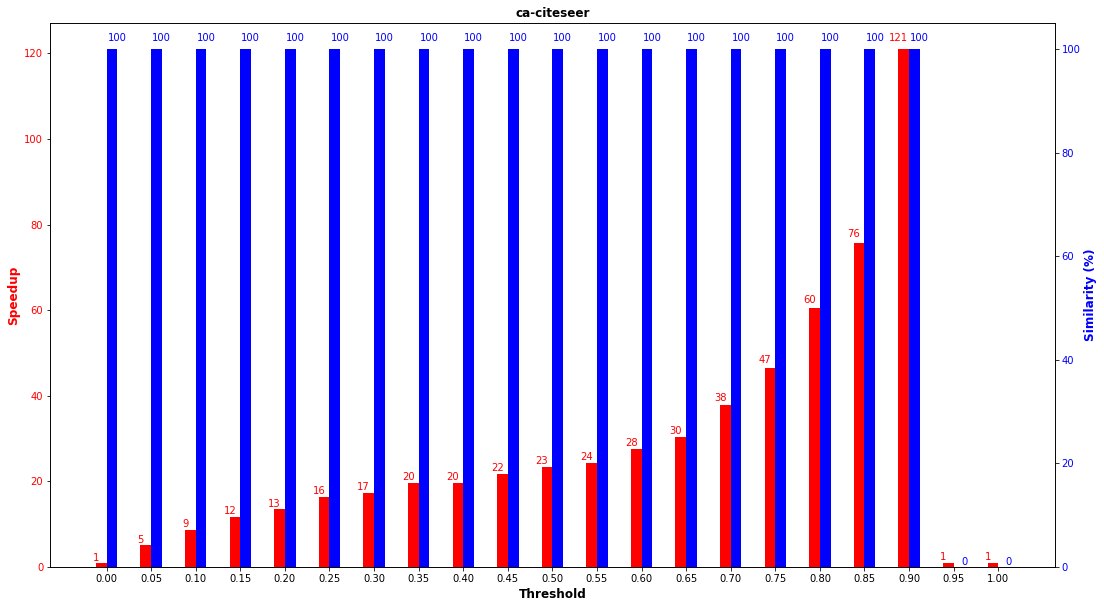

################################################################################################################################################


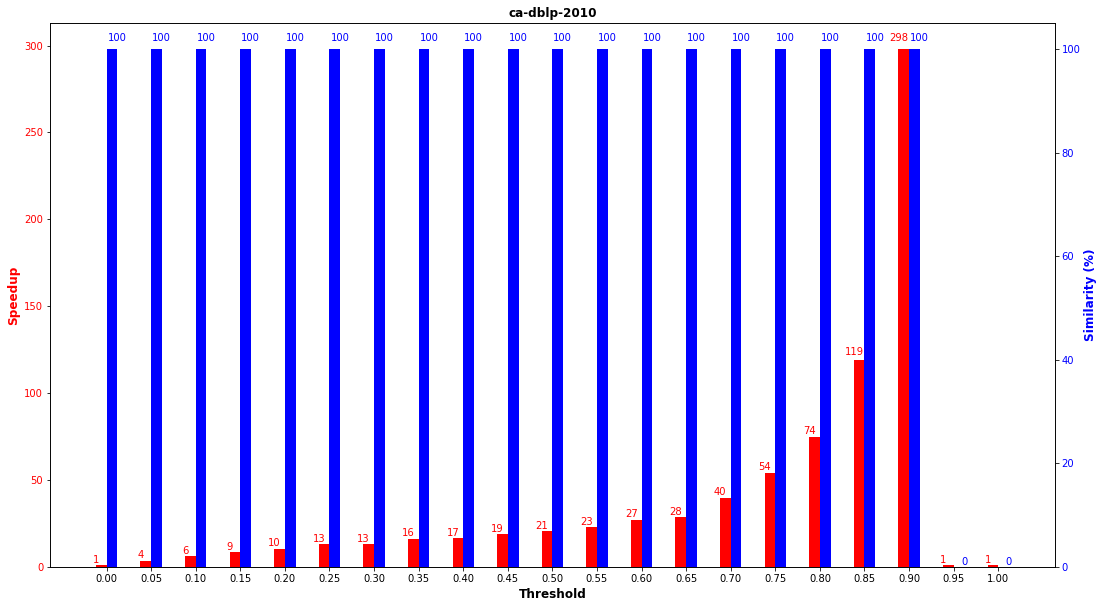

################################################################################################################################################


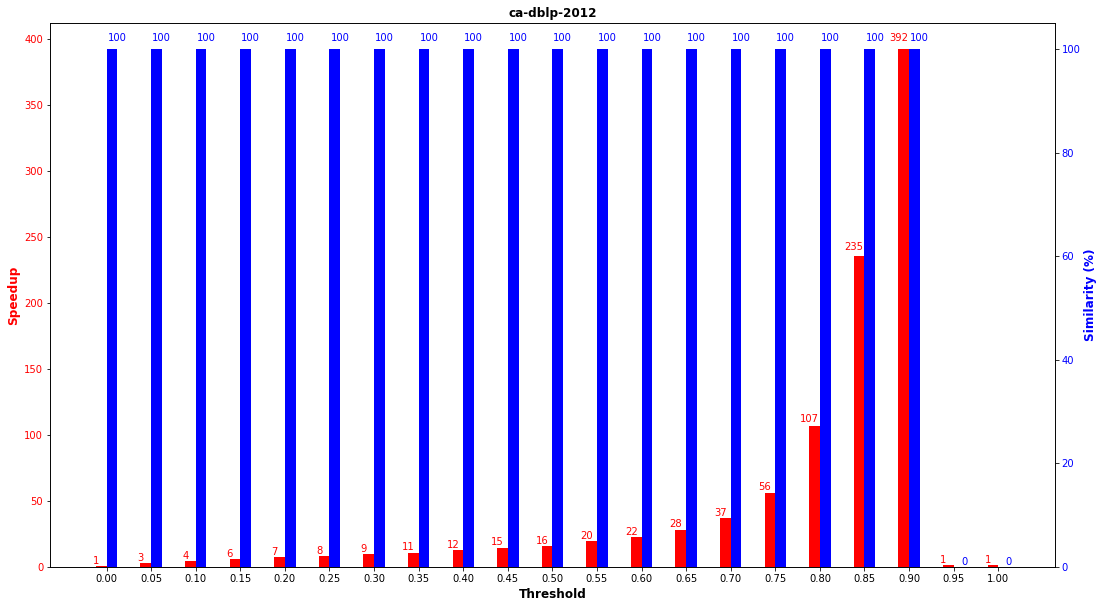

################################################################################################################################################


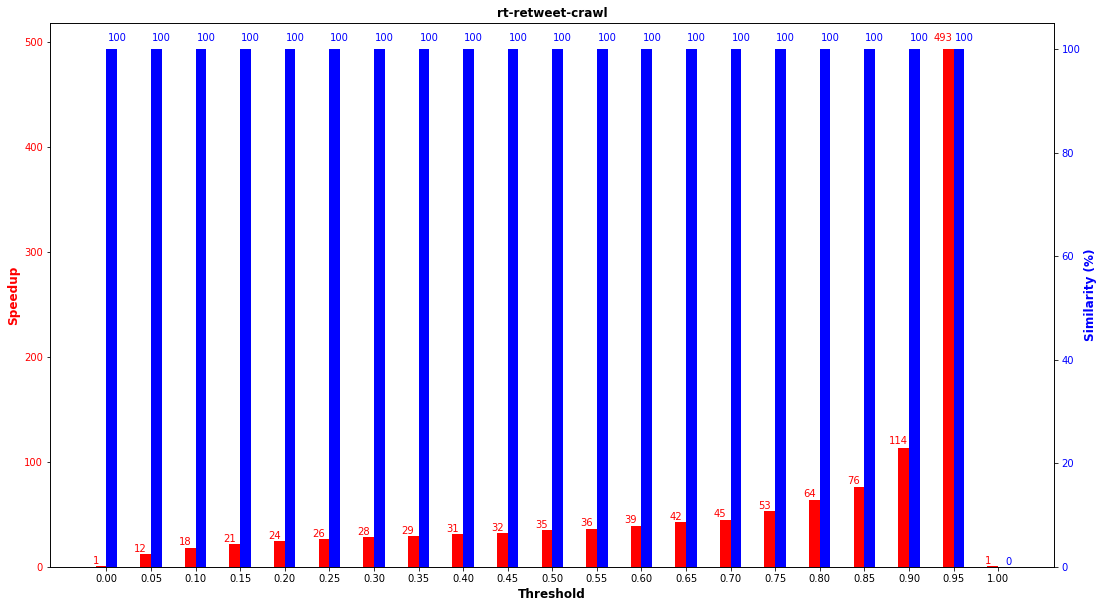

################################################################################################################################################


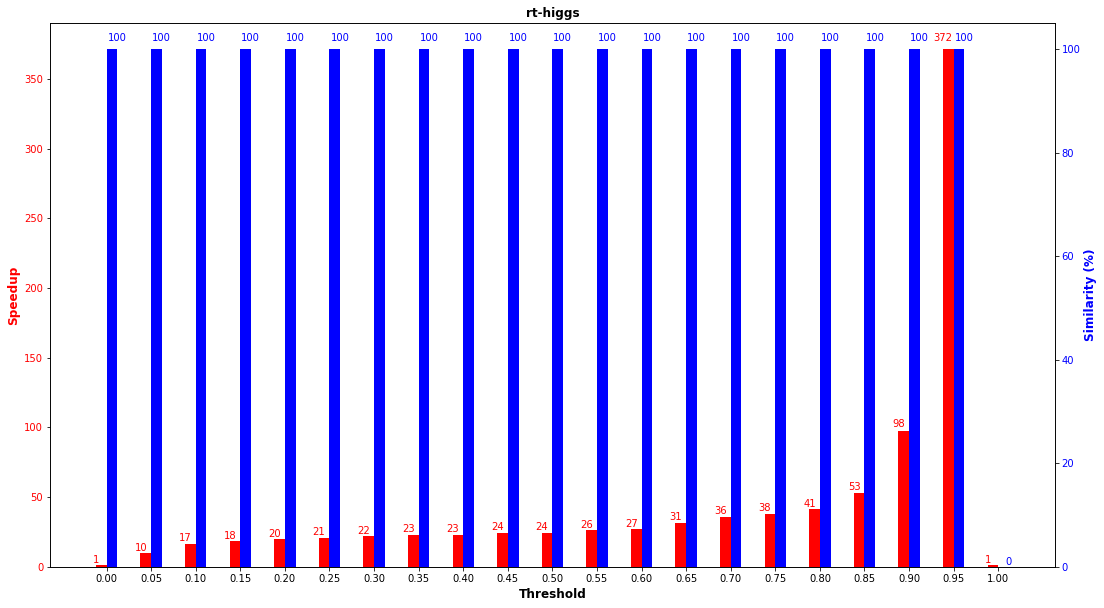

################################################################################################################################################


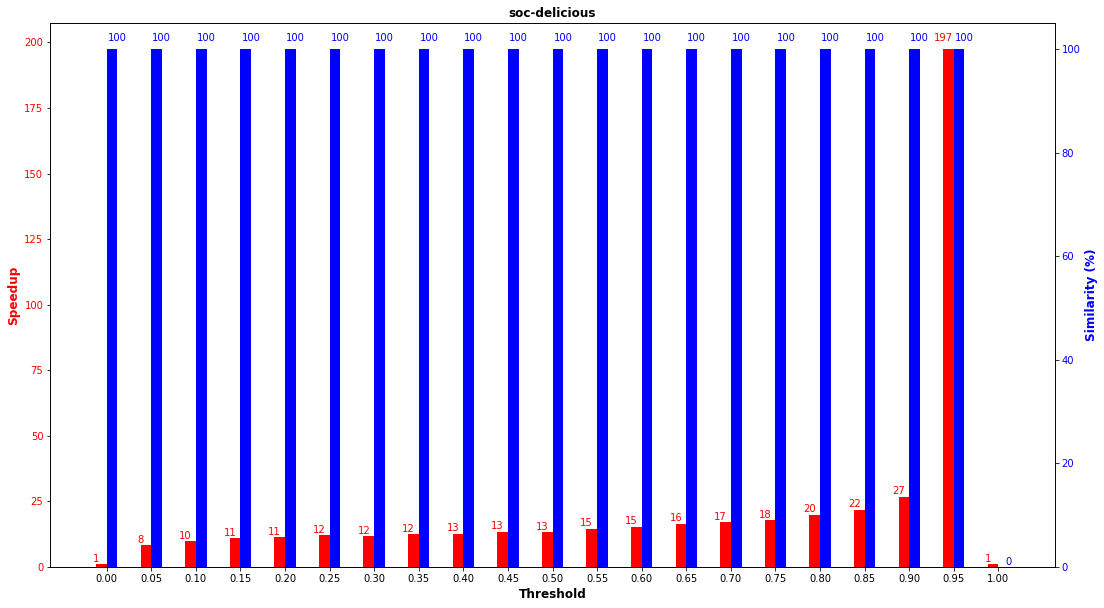

################################################################################################################################################


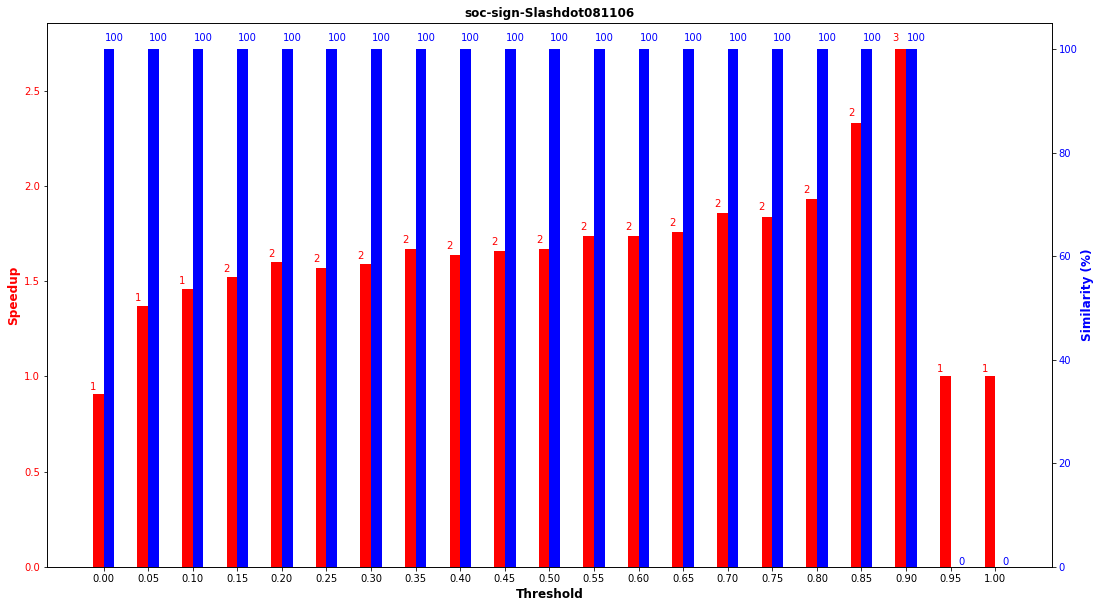

################################################################################################################################################


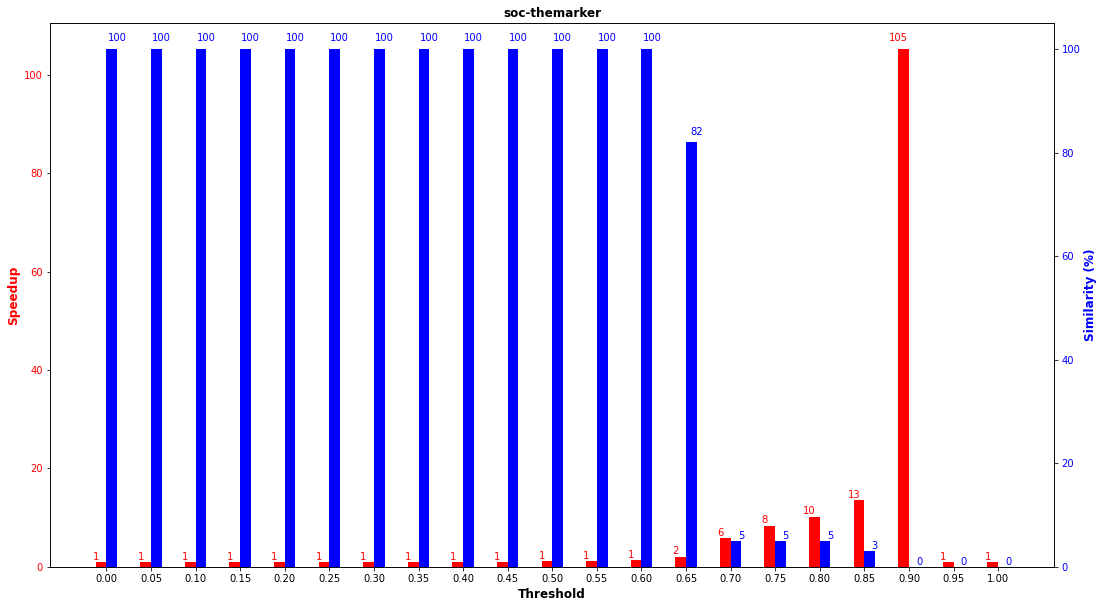

################################################################################################################################################


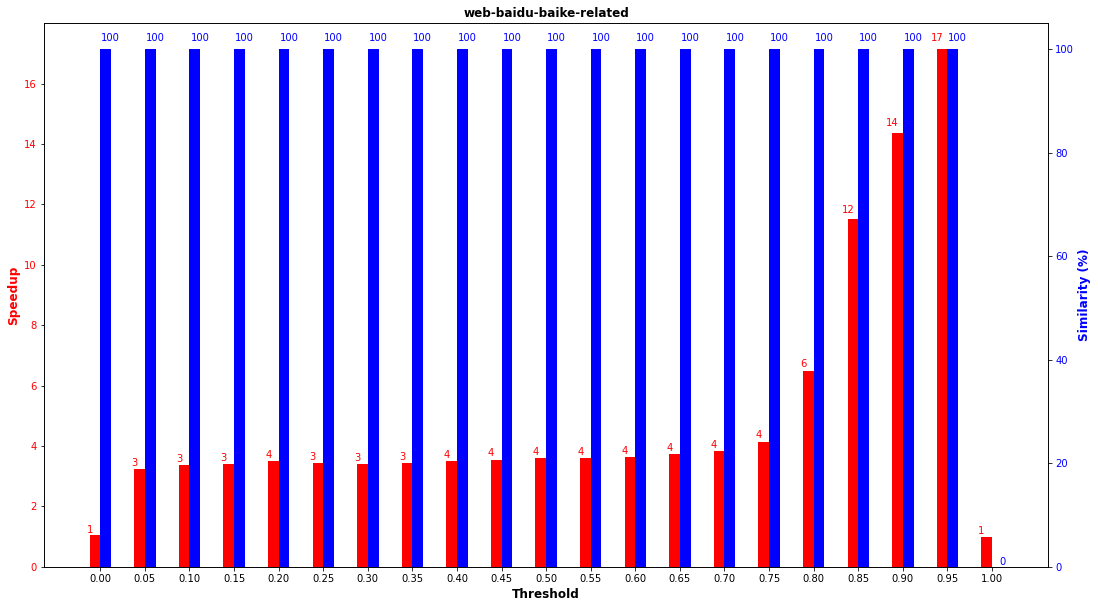

################################################################################################################################################


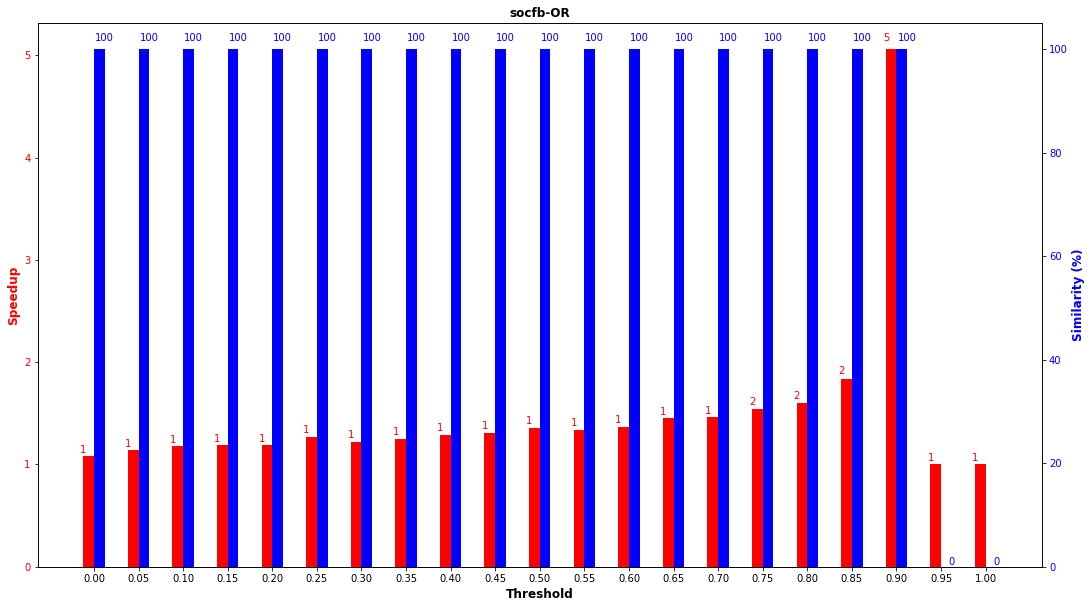

################################################################################################################################################


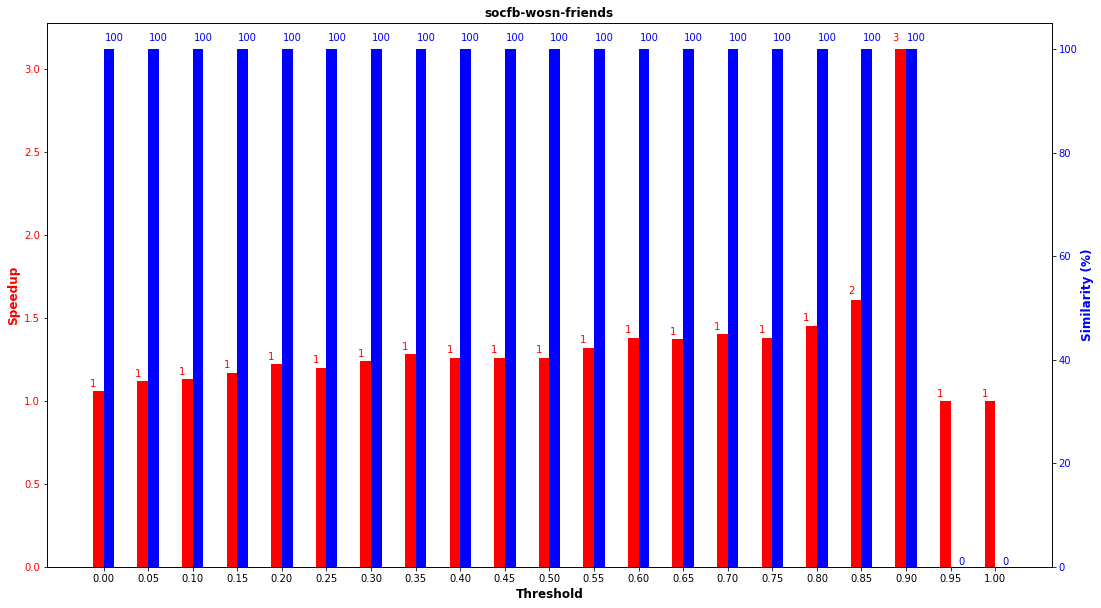

################################################################################################################################################


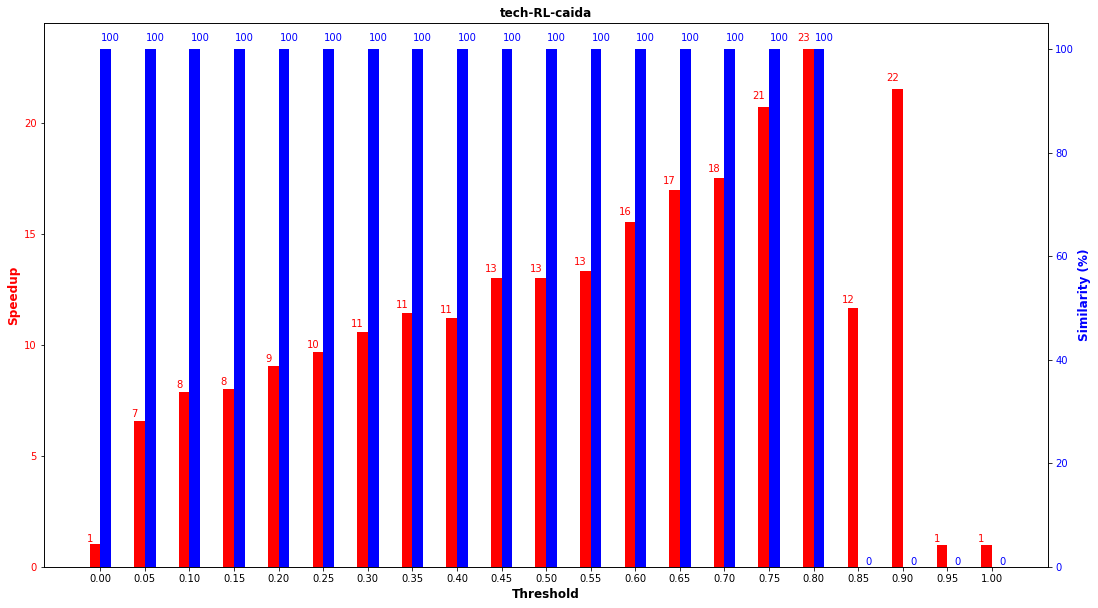

In [33]:
for i in range(0, len(dict_speedups_for_each_graph)):
  print("#"*144)
  fig, ax = plt.subplots()
  bar1 = ax.bar(thresholds-0.006, dict_speedups_for_each_graph[dataset_testing[i]], color='red', width = 0.012)
  ax.tick_params(axis='y', labelcolor='red')
  ax.set_xlabel("Threshold",fontweight ='bold', fontsize = 12)
  ax.set_ylabel("Speedup",fontweight ='bold', fontsize = 12, color="red")
  ax.set_xticks(thresholds)
  # Generate a new Axes instance, on the twin-X axes (same position)
  ax2 = ax.twinx()
  bar2 = ax2.bar(thresholds+0.006, dict_similarities_for_each_graph[dataset_testing[i]], color='blue',width = 0.012)
  ax2.tick_params(axis='y', labelcolor='blue')
  ax2.set_xlabel("Threshold",fontweight ='bold', fontsize = 12)
  ax2.set_ylabel("Similarity (%)",fontweight ='bold', fontsize = 12, color="blue")
  ax2.set_xticks(thresholds)
  fig.set_figheight(10)
  fig.set_figwidth(18)
  #Per aggiungere una label ad ogni singola barra
  for rect in bar1:
   height = rect.get_height()
   ax.text(rect.get_x() + rect.get_width()/40.5, height*1.012, f'{height:.0f}', ha='center', va='bottom', color="red")
  for rect in bar2:
   height = rect.get_height()
   ax2.text(rect.get_x() + rect.get_width()/1.03, height*1.012, f'{height:.0f}', ha='center', va='bottom', color="blue")
  plt.title(dataset_testing[i],fontweight ='bold')
  plt.show()

In [34]:
average_speedups_for_each_threshold_list = []
average_similarities_for_each_threshold_list = []

In [35]:
for i in range(0,len(thresholds)):
  somma_speedups_all_graphs_threshold_i = 0
  for speedups_graph in dict_speedups_for_each_graph.values():
    somma_speedups_all_graphs_threshold_i = somma_speedups_all_graphs_threshold_i + speedups_graph[i]
  average_speedups_all_graphs_threshold_i = somma_speedups_all_graphs_threshold_i / len(dict_speedups_for_each_graph)
  average_speedups_for_each_threshold_list.append(average_speedups_all_graphs_threshold_i)
for i in range(0,len(thresholds)):
  somma_similarities_all_graphs_threshold_i = 0
  for similarities_graph in dict_similarities_for_each_graph.values():
    somma_similarities_all_graphs_threshold_i = somma_similarities_all_graphs_threshold_i + similarities_graph[i]
  average_similarities_all_graphs_threshold_i = somma_similarities_all_graphs_threshold_i / len(dict_similarities_for_each_graph)
  average_similarities_for_each_threshold_list.append(average_similarities_all_graphs_threshold_i)

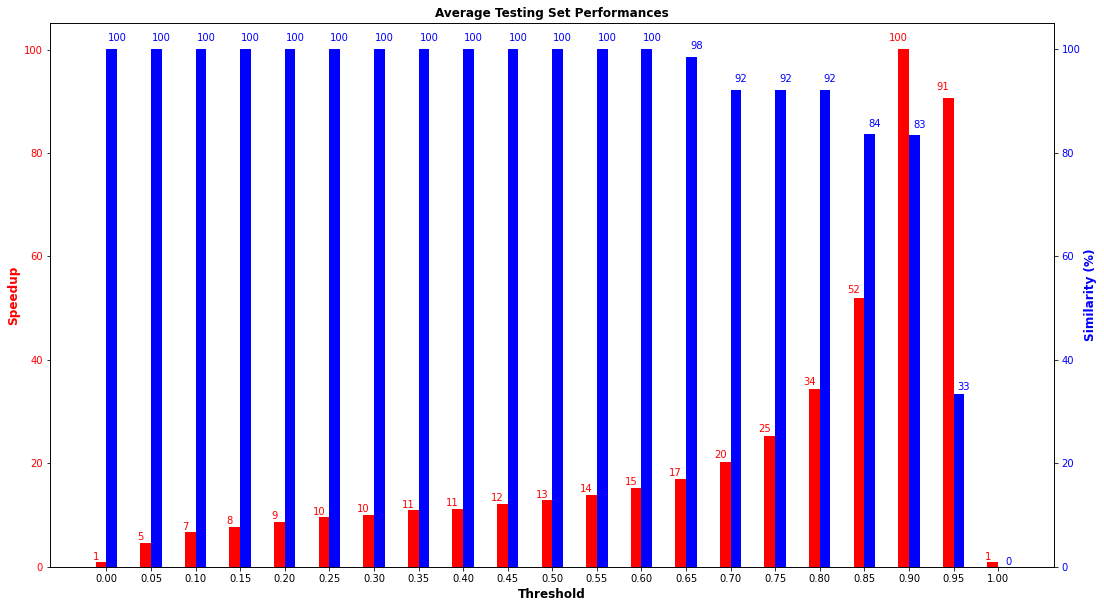

In [36]:
fig, ax = plt.subplots()
bar1 = ax.bar(thresholds-0.006, average_speedups_for_each_threshold_list, color='red', width = 0.012)
ax.tick_params(axis='y', labelcolor='red')
ax.set_xlabel("Threshold",fontweight ='bold', fontsize = 12)
ax.set_ylabel("Speedup",fontweight ='bold', fontsize = 12, color="red")
ax.set_xticks(thresholds)
# Generate a new Axes instance, on the twin-X axes (same position)
ax2 = ax.twinx()
bar2 = ax2.bar(thresholds+0.006, average_similarities_for_each_threshold_list, color='blue',width = 0.012)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_xlabel("Threshold",fontweight ='bold', fontsize = 12)
ax2.set_ylabel("Similarity (%)",fontweight ='bold', fontsize = 12, color="blue")
ax2.set_xticks(thresholds)
fig.set_figheight(10)
fig.set_figwidth(18)
#Per aggiungere una label ad ogni singola barra
for rect in bar1:
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width()/40.5, height*1.012, f'{height:.0f}', ha='center', va='bottom', color="red")
for rect in bar2:
  height = rect.get_height()
  ax2.text(rect.get_x() + rect.get_width()/1.03, height*1.012, f'{height:.0f}', ha='center', va='bottom', color="blue")
plt.title("Average Testing Set Performances",fontweight ='bold')
plt.show()

# **Plot ROC Curve**

######################################################################################################################################################


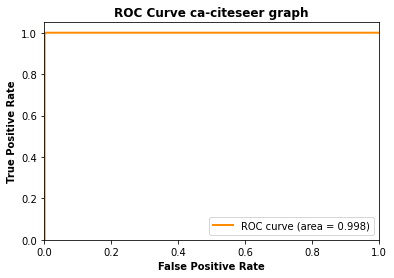

######################################################################################################################################################


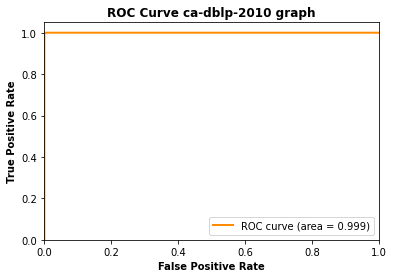

######################################################################################################################################################


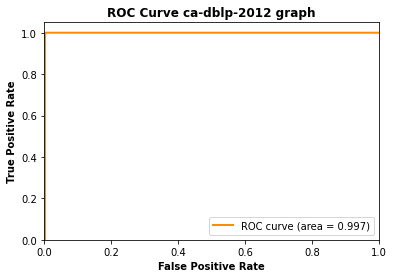

######################################################################################################################################################


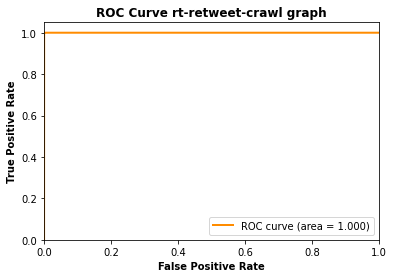

######################################################################################################################################################


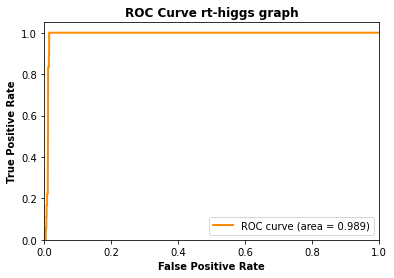

######################################################################################################################################################


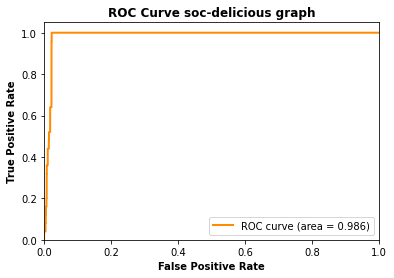

######################################################################################################################################################


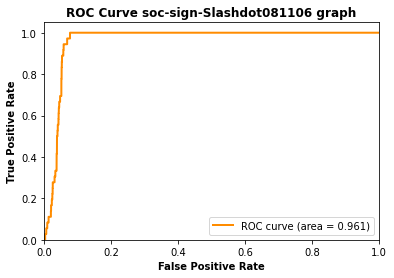

######################################################################################################################################################


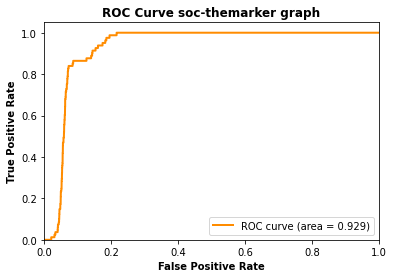

######################################################################################################################################################


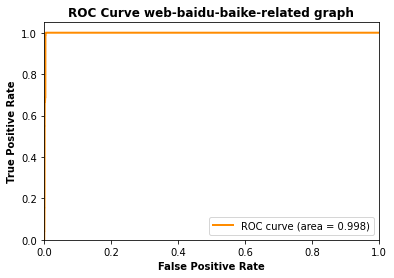

######################################################################################################################################################


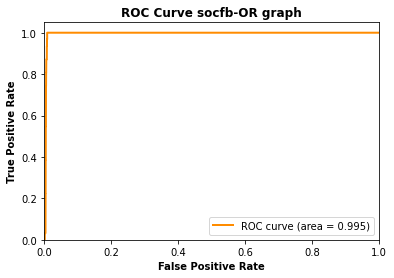

######################################################################################################################################################


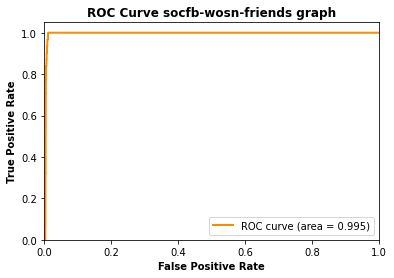

######################################################################################################################################################


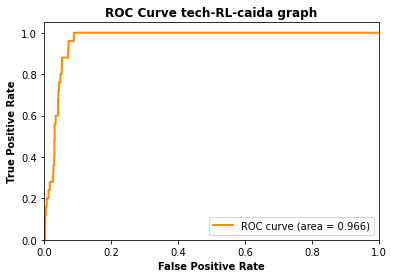

In [45]:
for i in range(0,len(dizionario_grafi["Testing"])):
  print("#"*150)
  plt.figure()
  plt.plot(fpr[dataset_testing[i]], tpr[dataset_testing[i]], color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % roc_auc[dataset_testing[i]])
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate',fontweight ='bold')
  plt.ylabel('True Positive Rate',fontweight ='bold')
  plt.title('ROC Curve '+ dataset_testing[i] + ' graph',fontweight ='bold')
  plt.legend(loc="lower right")
  plt.show()

In [46]:
predictions_all_graphs = torch.tensor(list(dict_predictions_all_graphs[dataset_testing[0]]))
targets_all_graphs = torch.tensor(list(dizionario_dataset["Testing"][0].y))
for i in range(1,len(dizionario_grafi["Testing"])):
  predictions_all_graphs = torch.cat((predictions_all_graphs,dict_predictions_all_graphs[dataset_testing[i]].cpu()))
  targets_all_graphs = torch.cat((targets_all_graphs,dizionario_dataset["Testing"][i].y.cpu()))

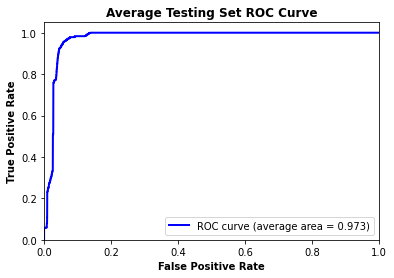

In [47]:
fpr["Average"], tpr["Average"], _ = roc_curve(targets_all_graphs.cpu(), predictions_all_graphs.cpu().numpy())
roc_auc["Average"] = roc_auc_score(targets_all_graphs.cpu(), predictions_all_graphs.cpu().numpy())
plt.figure()
plt.plot(fpr["Average"], tpr["Average"], color='blue',
         lw=2, label='ROC curve (average area = %0.3f)' % roc_auc["Average"])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontweight ='bold')
plt.ylabel('True Positive Rate',fontweight ='bold')
plt.title('Average Testing Set ROC Curve',fontweight ='bold')
plt.legend(loc="lower right")
plt.show()